In [1]:
import sys
sys.path.append("../script/")

from sklearn.metrics import classification_report,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
import Functions
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

import numpy as np
import pandas as pd
from time import time

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# Estimator

In [2]:
class Estimator:
    def __init__(self,bins=None,lam=None):
        self.bins = bins
        self.lam = lam

    def set_bins_params(self,val):
        bins = self.bins
        val_max = np.max(val)
        val_min = np.min(val)
        width = ((val_max - val_min)/bins)

        self.val_min = val_min
        self.width = width

    def fit(self,val,residual,p):
        self.set_bins_params(val)
        index = self.get_index(val)

        residual_bin = np.stack([np.sum(residual[index==i],axis=0) for i in range(self.bins)])
        cover_bin = np.stack([np.sum(np.multiply(p[index==i],1-p[index==i]),axis=0) for i in range(self.bins)])
        cover_bin = cover_bin + self.lam #lambda

        grad_bin = np.divide(residual_bin,cover_bin,where=cover_bin!=0,out=np.zeros(cover_bin.shape))
        
        self.residual_bin = residual_bin
        self.cover_bin = cover_bin
        self.grad_bin = grad_bin
        
        grads = self.get_grads(index)

        return grads


    def get_index(self,val):
        index = ((val - self.val_min)//self.width).astype('int32') if self.width !=0 else np.zeros(val.shape[0])
        index = np.where(index >= self.bins,self.bins-1,index)
        index = np.where(index < 0,0,index)

        return index

    def get_grads(self,index):
        grads = np.zeros((index.shape[0],self.grad_bin.shape[1]))
        for i in range(self.bins):
            grads[index==i] = self.grad_bin[i]
        return grads


    def predict_grad(self,val):
        index = self.get_index(val)
        grads = self.get_grads(index)
        return grads

# Decision Tree Estimator

In [3]:
class Estimator_DC:
    def __init__(self,max_depth=None,lam=None):
        self.max_depth = max_depth
        self.lam = lam

    def set_grads_bin(self,residual,p):
        residual_bin = np.stack([np.sum(residual[self.index==i],axis=0) for i in range(self.bins)])
        cover_bin = np.stack([np.sum(np.multiply(p[self.index==i],1-p[self.index==i]),axis=0) for i in range(self.bins)])
        cover_bin = cover_bin + self.lam #lambda

        grad_bin = np.divide(residual_bin,cover_bin,where=cover_bin!=0,out=np.zeros(cover_bin.shape))

        self.residual_bin = residual_bin
        self.cover_bin = cover_bin
        self.grad_bin = grad_bin

        return self.get_grads(self.index)

    def fit(self,val,y):
        val = val.reshape(-1,1)

        self.clf = DecisionTreeClassifier(max_depth=self.max_depth,class_weight='balanced')
        # self.clf = DecisionTreeClassifier(max_depth=self.max_depth,class_weight={0:1,1:1,2:1})
        # self.clf = DecisionTreeClassifier(max_depth=self.max_depth)
        self.clf.fit(val,y)
        self.index = self.get_index(val)
        
        self.bins = len(self.clf.tree_.threshold)

    # def get_loss(self,base_gini):
    #     self.loss = -(base_gini - np.sum(self.clf.tree_.impurity))

    #     return self.loss

    def get_loss(self):
        impurity = self.clf.tree_.impurity[self.clf.tree_.children_right == -1]
        weighted_node = self.clf.tree_.weighted_n_node_samples[self.clf.tree_.children_right == -1]

        self.loss = impurity@(weighted_node/sum(weighted_node))

        # self.loss = self.clf.tree_.impurity@(self.clf.tree_.weighted_n_node_samples/sum(self.clf.tree_.weighted_n_node_samples))
        # self.loss = self.clf.tree_.impurity@(self.clf.tree_.n_node_samples/sum(self.clf.tree_.n_node_samples))
        return self.loss

    # def get_loss(self,grads,log_odds,p,learning_rate):
        # log_odds_1 = log_odds + learning_rate * grads
        
        # p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
        # p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
        
        # self.loss = np.sum(np.power(self.Y - p_1,2))
        # self.loss = -np.sum(np.power(self.p - p_1,2))
        # self.loss = -np.sum(np.abs(grads))
    #     return self.loss

    def get_index(self,val):
        val = val.reshape(-1,1)
        index = self.clf.apply(val)

        return index

    def get_grads(self,index):
        grads = np.zeros((index.shape[0],self.grad_bin.shape[1]))
        for i in range(self.bins):
            grads[index==i] = self.grad_bin[i]
        return grads


    def predict_grad(self,val):
        index = self.get_index(val)
        grads = self.get_grads(index)
        return grads

# Node

In [4]:
class Node:
    def __init__(self,terminal,func=None,sons=None,index=None,fit=None,estimator=None):
        self.terminal = terminal
        self.sons = sons
        self.func = func
        self.index = index
        self.fitness = fit
        self.estimator = estimator
        if self.terminal:
            self.depth = 0
            self.numNode = 1
        else:
            self.depth = max([s.depth for s in sons]) + 1
            self.numNode = sum([s.numNode for s in sons])+ 1

    def predict_grad(self,X):
        val = self.predict_val(X)
        return self.estimator.predict_grad(val)
        
    def predict_val(self,X):
        X = X.astype('float64')
        return self.pred_rec(X.T)
    def pred_rec(self,X):
        if not self.terminal:
            return self.func([s.pred_rec(X) for s in self.sons])
        else:
            return X[self.index]
    def __str__(self):
        if self.terminal:
            return "|"+str(self.index)+"|"
        else:
            string = "( " + str(self.func.__name__) + " -> "
            for s in self.sons:
                string += str(s) + " "
            string += ")"
            return string
    def __repr__(self):
        if self.terminal:
            return "|"+str(self.index)+"|"
        else:
            string = "( " + str(self.func.__name__) + " -> "
            for s in self.sons:
                string += str(s) + " "
            string += ")"
            return string

# Engine

In [5]:
class Engine:
    def __init__(self,opset,X,Y,Y_one_hot,log_odds,p,learning_rate,bins):
        self.generation = 0
        
        X = X.astype('float64')
        self.opset = opset
        
        self.feature_space = X.shape[1]
        
        self.vals = X.T
        self.X = X
        self.Y = Y
        self.Y_one_hot = Y_one_hot

        base_gini = (pd.value_counts(y_train)/y_train.shape)
        self.base_gini = sum(base_gini*(1-base_gini))

        self.log_odds = log_odds
        self.p = p
        self.residual = Y_one_hot - p
        self.learning_rate = learning_rate
        self.bins = bins
        
        self.best = (np.inf,None)
        self.nodes = [Node(True,index=i) for i in range(self.feature_space)]
    
    # def calculate_grad(self,val,lam):
    #     bins = self.bins
    #     val_max = np.max(val)
    #     val_min = np.min(val)
    #     width = ((val_max - val_min)/bins)

    #     index = ((val - val_min)//width).astype('int32') if width != 0 else np.zeros(val.shape[0])
    #     index = np.where(index >= bins,bins-1,index)
    #     index = np.where(index < 0,0,index)

    #     residual_bin = np.stack([np.sum(self.residual[index==i],axis=0) for i in range(bins)])
    #     p_bin = np.stack([np.sum(np.multiply(self.p[index==i],1-self.p[index==i]),axis=0) for i in range(bins)]) + lam
    #     grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))

    #     grads = np.zeros(self.log_odds.shape)
    #     for i in range(bins):
    #         grads[index==i] = grad_bin[i]
            
    #     return grads

    
    def calculate_fitness(self,vals,lam=0,max_depth=3):
        fitness = []
        estimators = []
        for val in vals:
            # est = Estimator(self.bins,lam)
            # grads = est.fit(val,self.residual,self.p)
            est = Estimator_DC(max_depth,lam)
            est.fit(val,self.Y)

            # grads = est.set_grads_bin(self.residual,self.p)
            # loss = est.get_loss(grads,self.log_odds,self.p,self.learning_rate)

            # loss = est.get_loss(self.base_gini)
            
            loss = est.get_loss()
            
            fitness.append(loss)
            estimators.append(est)

        return fitness,estimators
    

    def evolve(self,total_size,batch_size,elite_size,lam=0,max_depth=3,verbose=0):
        self.generation += 1
        
        if verbose:
            print("\tgeneration:",self.generation)
            t = time()
        
        num_batches = total_size//batch_size
        pool = self.nodes

        elites_funcs = []
        elite_sons = []
        elite_vals = []

        elites_fitness = []
        elites_estimator = []

        for j in range(num_batches):

            funcs = np.random.choice(list(self.opset.keys()),size=batch_size)
            arg_count = [self.opset[func] for func in funcs]
            sons = np.random.choice(pool,size = sum(arg_count))
            it = iter(sons)
            sons = [[next(it) for _ in range(arg_count[i])] for i in range(batch_size)]
            vals = [funcs[i]([self.vals[s.index] for s in sons[i]]) for i in range(batch_size)]

            vals = np.stack(vals)
            fitness,estimators = self.calculate_fitness(vals,lam,max_depth)
            # fitness = self.calculate_decision(vals,1,lam)
            
            elites_funcs.extend(funcs)
            elite_sons.extend(sons)
            elite_vals.extend(vals)
            elites_fitness.extend(fitness)
            elites_estimator.extend(estimators)

            rank = np.argsort(elites_fitness)

            elites_funcs = [elites_funcs[index] for index in rank[:elite_size]]
            elite_sons = [elite_sons[index] for index in rank[:elite_size]]
            elite_vals = [elite_vals[index] for index in rank[:elite_size]]
            elites_fitness = [elites_fitness[index] for index in rank[:elite_size]]
            elites_estimator = [elites_estimator[index] for index in rank[:elite_size]]

        for index in range(elite_size):
            node = Node(False,
                func=elites_funcs[index],
                sons=elite_sons[index],
                index=len(self.nodes),
                fit=elites_fitness[index],
                estimator=elites_estimator[index]
            )
            if index == 0:
                if self.best[0] > node.fitness:
                    self.best = (node.fitness,node)
            self.nodes.append(node)
            self.vals = np.append(self.vals,[elite_vals[index]],axis=0)
            # self.test_param_same(node)
      

        if verbose:
            print("\t",np.max(elites_fitness))
            print("\ttime",time()-t)
        return None

    def test_param_same(self,node):
        v1 = node.predict_val(self.X)
        v2 = self.vals[node.index]
        if np.any(v1!=v2):
            print(node.index,v1==v2)

# Stack

In [6]:
def adding_unique_node(stack,losses,new_nodes,tolerance):
    protect_losses = [-np.inf] + losses + [np.inf]
    protect_stack = [None] + stack + [None]
    new_losses = [ node.estimator.loss for node in new_nodes]

    for i in range(len(new_losses)):
        new_loss = new_losses[i]
        new_node = new_nodes[i]
        
        index = np.searchsorted(protect_losses,new_loss,side='left')
        left_index = index - 1
        right_index = index 

        left_diff = new_loss - protect_losses[left_index]
        left_node = protect_stack[left_index]

        right_diff = protect_losses[right_index] - new_loss
        right_node = protect_stack[right_index]

        mid_flag,left_flag,right_flag = (1,1,1)

        if left_diff < tolerance:
            if left_node.numNode <= new_node.numNode:
                mid_flag = 0
            else:
                left_flag = 0
        if right_diff < tolerance:
            if right_node.numNode <= new_node.numNode:
                mid_flag = 0
            else:
                right_flag = 0
        
        if mid_flag == 1:
            if right_flag == 0:
                protect_stack.pop(right_index)
                protect_losses.pop(right_index)
                
            protect_stack.insert(index,new_node)
            protect_losses.insert(index,new_loss)

            if left_flag == 0:
                protect_stack.pop(left_index)
                protect_losses.pop(left_index)
    
    losses = protect_losses[1:-1]
    stack = protect_stack[1:-1]

    return stack,losses

In [7]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p
    
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        grads = node.predict_grad(X)
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

# Covertype

In [2]:
df = pd.read_csv("../data/covtype.data",delimiter=',')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify=y)

In [4]:
df

,2596,51,3,258,0,510,221,232,148,6279,...,0.34,0.35,0.36,0.37,0.38,0.39,0.40,0.41,0.42,5
0,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
1,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
2,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
3,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5
4,2579,132,6,300,-15,67,230,237,140,6031,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581006,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,3
581007,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,3
581008,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,3
581009,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,3


In [10]:
feature_space = X_train.shape[1]
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

learning_rate = 0.3
lam = 1
max_depth = 6
bins = 10

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

stack = []
losses = []

for i in range(feature_space):
    val = X_train[:,i]
    est = Estimator_DC(max_depth,lam)
    est.fit(val,y_train)
    loss = est.get_loss()

    node = Node(terminal=True,index=i,fit=loss,estimator=est)
    stack.append(node)
    losses.append(loss)
index = np.argsort(losses)
losses = [losses[i] for i in index]
stack = [stack[i] for i in index]

In [19]:
tolerance = min([losses[i] - losses[i-1] for i in range(1,len(losses))])/5
# tolerance = 0.000001
i = 0

epoch = 10

total = 10
elite = 3


while len(stack) < 20000:
        eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,log_odds,p,learning_rate,bins)
        for j in range(epoch):
                eg.evolve(total,total,elite,lam,max_depth,0)
        # s.extend([eg.best[1]])
        newcomers = eg.nodes[-elite*epoch:]
        stack,losses = adding_unique_node(stack,losses,newcomers,tolerance)

        print(i,len(stack),sum([n.numNode for n in stack]))
        i += 1

0 2578 12946
1 2594 13030
2 2609 13107
3 2628 13212
4 2648 13316
5 2668 13434
6 2683 13515
7 2700 13594
8 2721 13695
9 2735 13763
10 2755 13863
11 2778 13964
12 2800 14056
13 2818 14162
14 2832 14226
15 2851 14337
16 2869 14463
17 2888 14560
18 2906 14646
19 2922 14722
20 2941 14833
21 2961 14937
22 2978 15034
23 2991 15135
24 3011 15243
25 3027 15319
26 3047 15415
27 3059 15483
28 3075 15571
29 3091 15653
30 3110 15740
31 3128 15836
32 3147 15937
33 3166 16028
34 3180 16100
35 3200 16206
36 3215 16277
37 3233 16381
38 3249 16469
39 3267 16559
40 3282 16650
41 3298 16736
42 3313 16827
43 3330 16908
44 3346 16988
45 3361 17073
46 3377 17165
47 3397 17291
48 3414 17400
49 3426 17476
50 3438 17532
51 3454 17624
52 3474 17740
53 3489 17819
54 3505 17917
55 3524 18044


KeyboardInterrupt: 

In [23]:
import warnings
warnings.filterwarnings("ignore")

fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

lam = 1000
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

train_acc = []
test_acc = []


train_sse = []
test_sse = []

counts = []


for i,node in enumerate(a):
    node.estimator.lam = lam
    grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

    test_grads = node.predict_grad(X_test)
    test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


    train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
    test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))
    print(train_sse[-1],test_sse[-1],i+1,len(a))


    pred = np.argmax(p,axis=1)
    train_acc.append(f1_score(pred,y_train,average='macro'))
    test_pred = np.argmax(test_p,axis=1)
    test_acc.append(f1_score(test_pred,y_test,average='macro'))


    # pred = np.argmax(p,axis=1)
    # train_acc.append(accuracy_score(pred,y_train))
    # test_pred = np.argmax(test_p,axis=1)
    # test_acc.append(accuracy_score(test_pred,y_test))

    print('\t',train_acc[-1],test_acc[-1],i+1,len(a))
    

381404.46163750254 381485.88442418264 1 3524
	 0.19178801319718367 0.19164908597057753 1 3524
291005.1528651045 291053.7980518278 2 3524
	 0.28075219940104196 0.2807240850679523 2 3524
237711.86545012682 237803.50552309526 3 3524
	 0.3481933088739364 0.34723827738970964 3 3524
204290.03599211684 204402.2618175919 4 3524
	 0.3595857999192596 0.35862491621975023 4 3524
182845.110825258 182969.81076768684 5 3524
	 0.36080884366762805 0.35987416029944486 5 3524
168675.43038810763 168803.200249041 6 3524
	 0.3617692016050031 0.36075561555172925 6 3524
159148.91999584733 159275.7334442636 7 3524
	 0.3661085752718071 0.3648686600132381 7 3524
152484.90155284462 152606.62755467277 8 3524
	 0.3675572227651858 0.36613291747501053 8 3524
147040.5662787334 147161.0211719211 9 3524
	 0.3682560628470351 0.3666003182561024 9 3524
142945.60429913644 143063.0822750741 10 3524
	 0.37025943508701303 0.3685513057941462 10 3524
139892.2019701868 140009.38040970662 11 3524
	 0.3701851601022104 0.36843773567

In [60]:
sum([n.numNode for n in stack[:5000]])

28544

In [61]:
test_acc[5000]

0.826904289647414

In [17]:
print(classification_report(y_train,np.argmax(p,axis=1),digits=5))

              precision    recall  f1-score   support

           0    0.81763   0.79086   0.80402    105920
           1    0.83047   0.86803   0.84883    141650
           2    0.88845   0.91335   0.90073     17877
           3    0.96945   0.97016   0.96981      1374
           4    0.93999   0.58744   0.72303      4746
           5    0.85624   0.77715   0.81478      8683
           6    0.94625   0.86689   0.90483     10255

    accuracy                        0.83583    290505
   macro avg    0.89264   0.82484   0.85229    290505
weighted avg    0.83666   0.83583   0.83517    290505



In [18]:

print(classification_report(y_test,np.argmax(test_p,axis=1),digits=5))

              precision    recall  f1-score   support

           0    0.79699   0.77587   0.78629    105920
           1    0.81306   0.85369   0.83288    141651
           2    0.81691   0.87302   0.84403     17877
           3    0.86703   0.69337   0.77054      1373
           4    0.87321   0.39760   0.54640      4746
           5    0.74569   0.62702   0.68122      8684
           6    0.91542   0.80312   0.85560     10255

    accuracy                        0.80974    290506
   macro avg    0.83261   0.71767   0.75957    290506
weighted avg    0.81027   0.80974   0.80787    290506



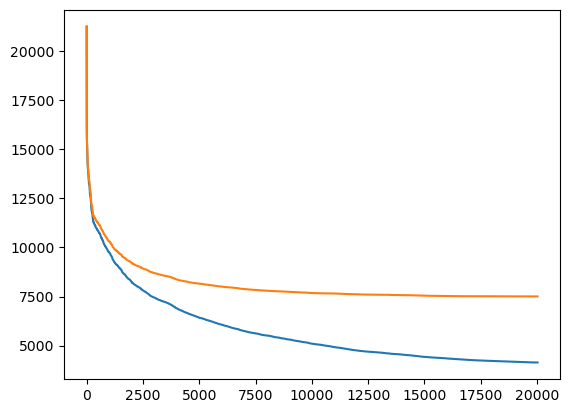

In [28]:
plt.plot(train_sse)
plt.plot(test_sse)

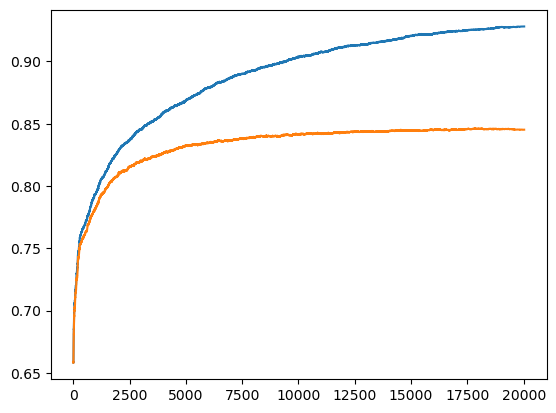

In [29]:
plt.plot(train_acc)
plt.plot(test_acc)

In [24]:
import xgboost

xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)

pred = xgb.predict_proba(X_train)

pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred,digits=3))

# pred = xgb.predict_proba(X_train)
# pred = pred[:,1]
# print(roc_auc_score(y_train,pred))

pred = xgb.predict_proba(X_test)

pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred,digits=3))

# pred = xgb.predict_proba(X_test)
# pred = pred[:,1]
# print(roc_auc_score(y_test,pred))

import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

              precision    recall  f1-score   support

           0      0.870     0.848     0.859    105920
           1      0.875     0.902     0.889    141650
           2      0.926     0.932     0.929     17877
           3      0.973     0.983     0.978      1374
           4      0.925     0.646     0.761      4746
           5      0.892     0.866     0.879      8683
           6      0.966     0.945     0.955     10255

    accuracy                          0.881    290505
   macro avg      0.918     0.875     0.893    290505
weighted avg      0.881     0.881     0.881    290505

              precision    recall  f1-score   support

           0      0.856     0.835     0.845    105920
           1      0.862     0.893     0.878    141651
           2      0.896     0.901     0.898     17877
           3      0.874     0.866     0.870      1373
           4      0.886     0.566     0.691      4746
           5      0.838     0.804     0.821      8684
           6      0.944 

(700, 6.0, 50646)